prices/sticker-crown-foil_EU2.csv processing...
(110, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  108.000
mean   515.452
std     57.335
min    448.000
25%    477.988
50%    502.620
75%    530.288
max    700.000


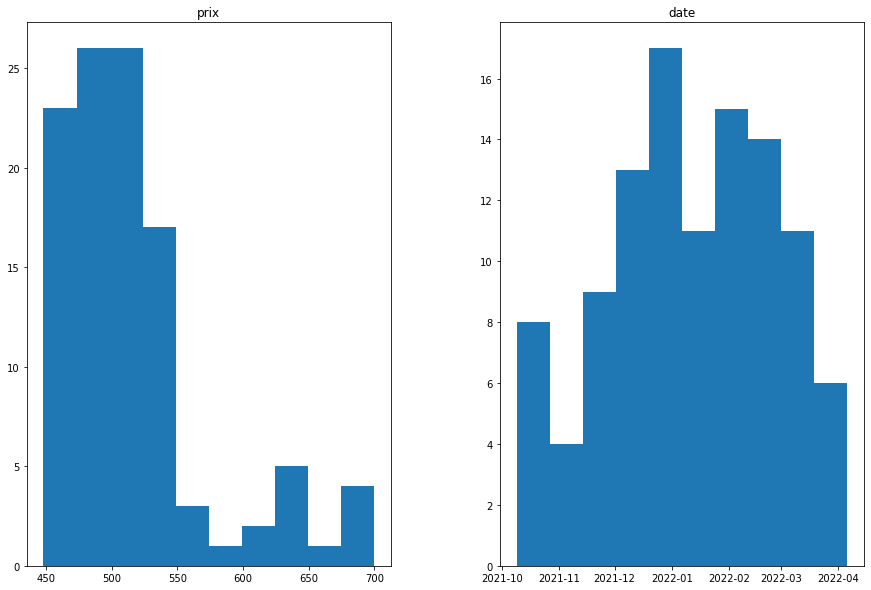

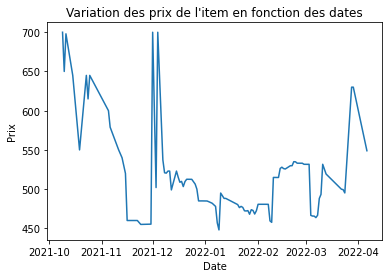

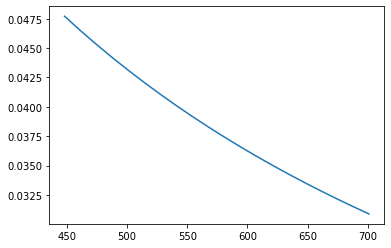

Comparaison des scores entre training, validation et test :  0.159513910404933 0.008604646722741749 0.03540715854590126
train error 2745.3244780235186
test error 5102.830039099733
R^2 (best possible value is 1.0) : 0.03540715854590126
The mean absolute error is: 50.87


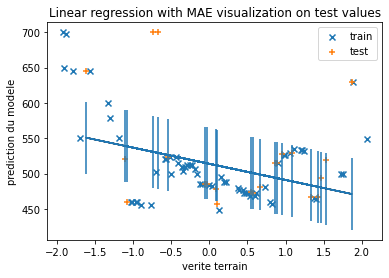

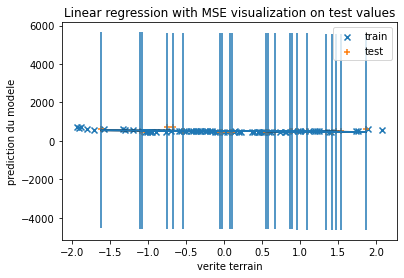

prices/falchion-knife-marble-fade-factory-new_EU3.csv processing...
(143, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  143.000
mean   164.519
std      7.440
min    150.990
25%    158.190
50%    163.800
75%    170.000
max    182.910


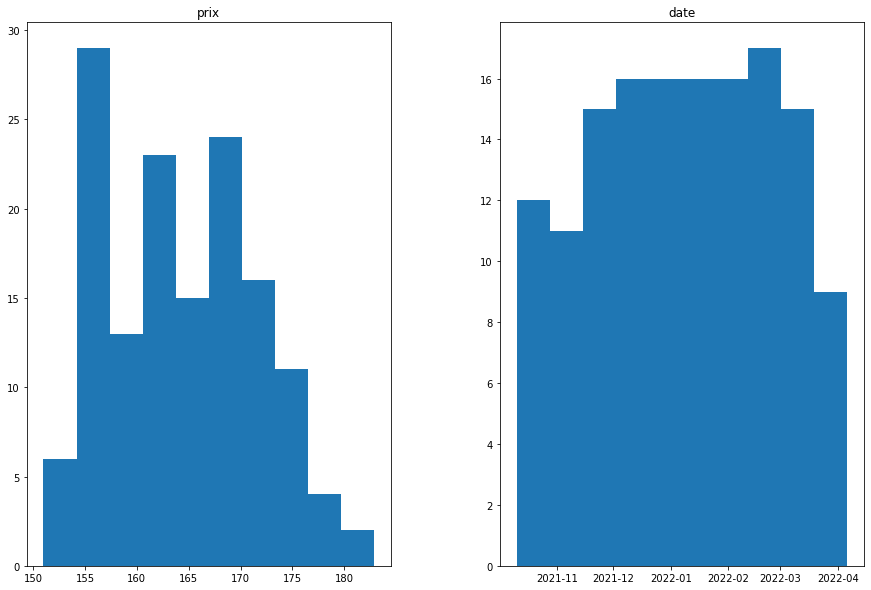

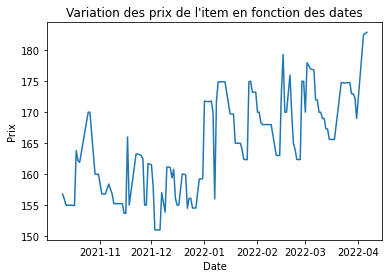

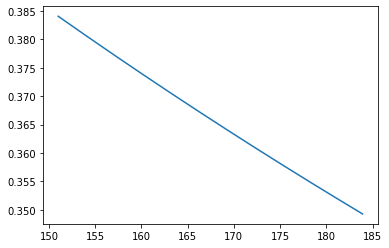

Comparaison des scores entre training, validation et test :  0.5135962699517296 0.49241803110521 0.3414995901882245
train error 28.788247676421076
test error 38.119403423266036
R^2 (best possible value is 1.0) : 0.3414995901882245
The mean absolute error is: 5.14


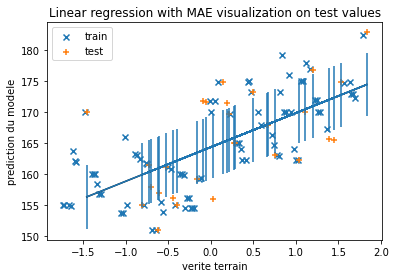

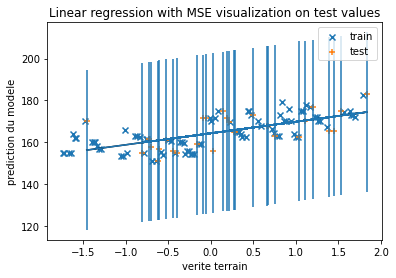

prices/usp-s-kill-confirmed-field-tested_EU2.csv processing...
(172, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  172.000
mean    37.442
std      2.895
min     31.550
25%     34.920
50%     37.190
75%     39.975
max     45.260


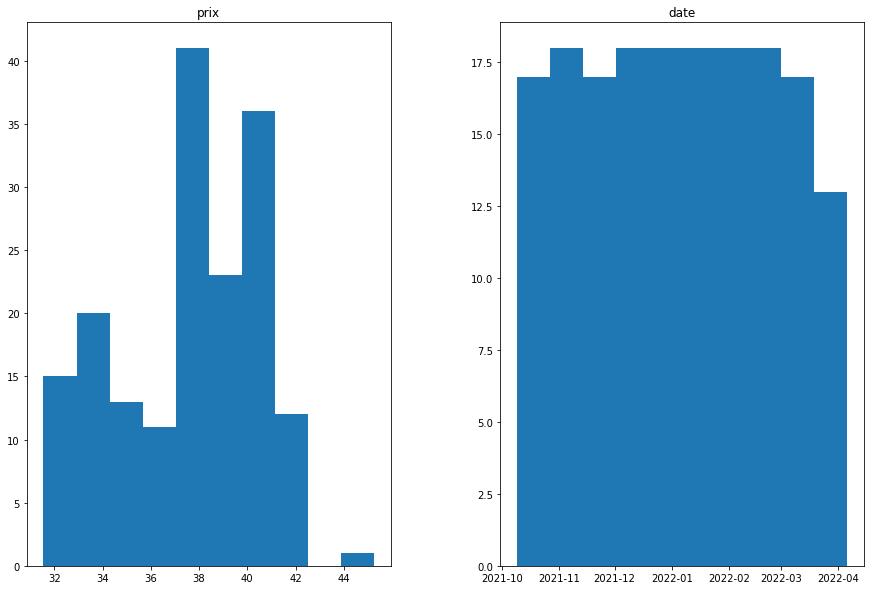

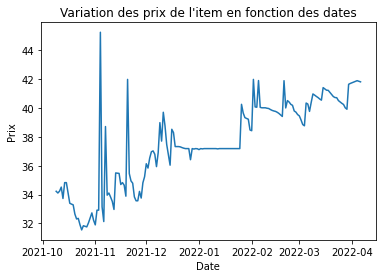

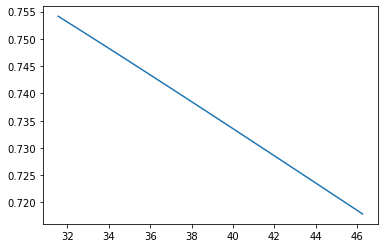

Comparaison des scores entre training, validation et test :  0.666160074664305 0.8072089379685863 0.8914227801006593
train error 3.0840168786171165
test error 0.6687130576607475
R^2 (best possible value is 1.0) : 0.8914227801006593
The mean absolute error is: 0.62


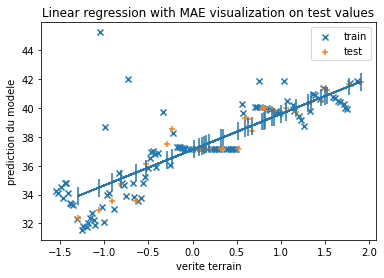

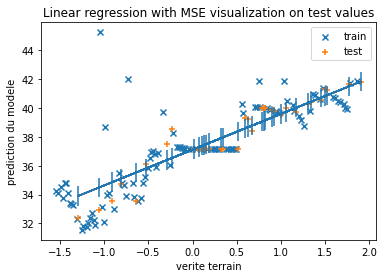

prices/m4a1-s-night-terror-field-tested_EU2.csv processing...
(60, 2)
prix           float64
date    datetime64[ns]
dtype: object
         prix
count  60.000
mean    4.742
std     2.532
min     2.680
25%     3.438
50%     3.910
75%     4.850
max    17.000


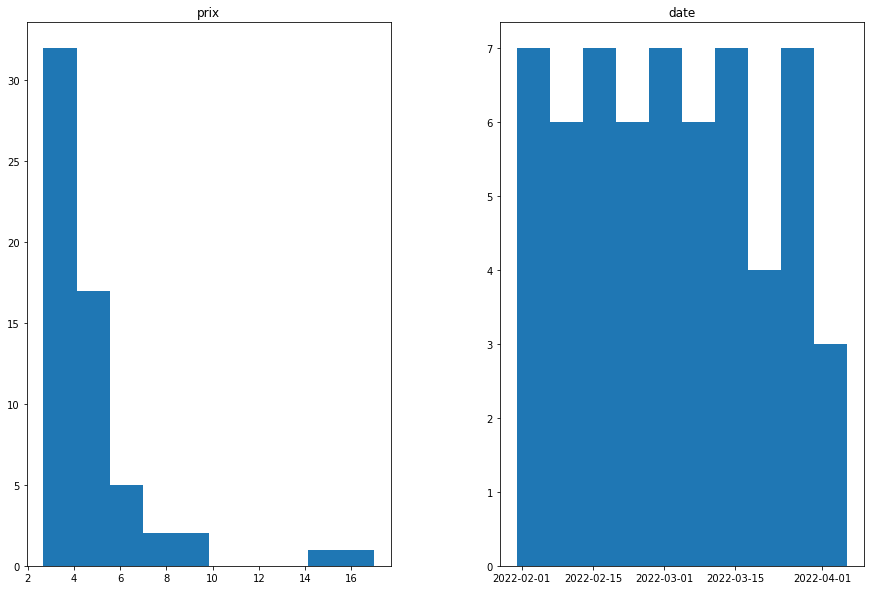

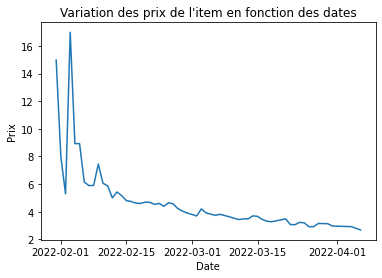

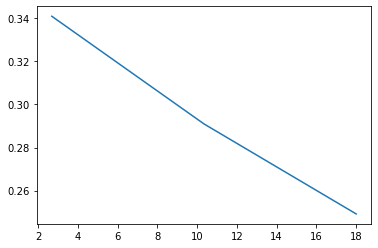

Comparaison des scores entre training, validation et test :  0.5398210963470116 0.3601961609107136 0.15623998733829492
train error 2.271124458454108
test error 0.6135049365397643
R^2 (best possible value is 1.0) : 0.15623998733829492
The mean absolute error is: 0.67


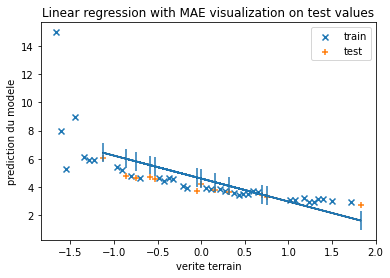

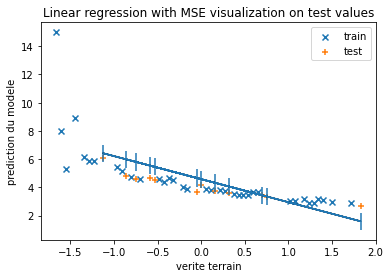

prices/navaja-knife-rust-coat-battle-scarred_buff.csv processing...
(173, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  173.000
mean    46.518
std      3.295
min     40.031
25%     43.956
50%     46.716
75%     49.608
max     53.375


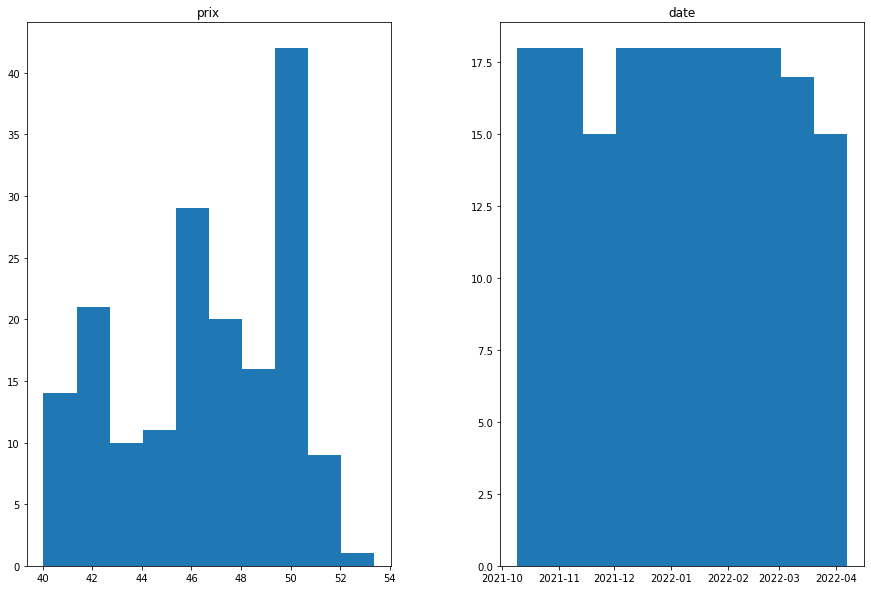

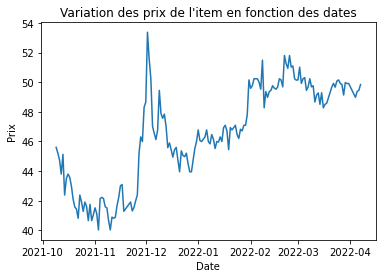

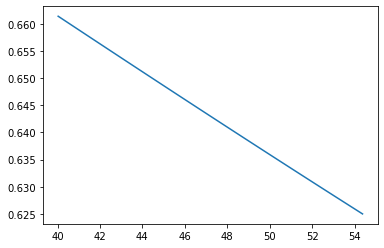

Comparaison des scores entre training, validation et test :  0.6533668376041148 0.7555296199613077 0.6178134283637104
train error 3.5582148164885807
test error 3.7882612179057813
R^2 (best possible value is 1.0) : 0.6178134283637104
The mean absolute error is: 1.23


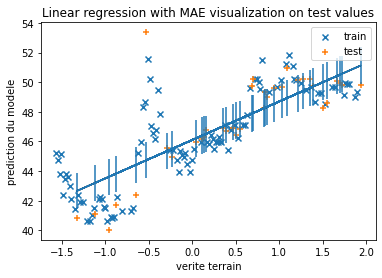

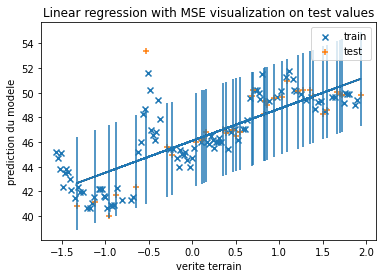

prices/m4a1-s-chanticos-fire-field-tested_EU1.csv processing...
(24, 2)
prix           float64
date    datetime64[ns]
dtype: object
         prix
count  23.000
mean   23.768
std     4.278
min    13.420
25%    21.970
50%    23.500
75%    23.876
max    35.000


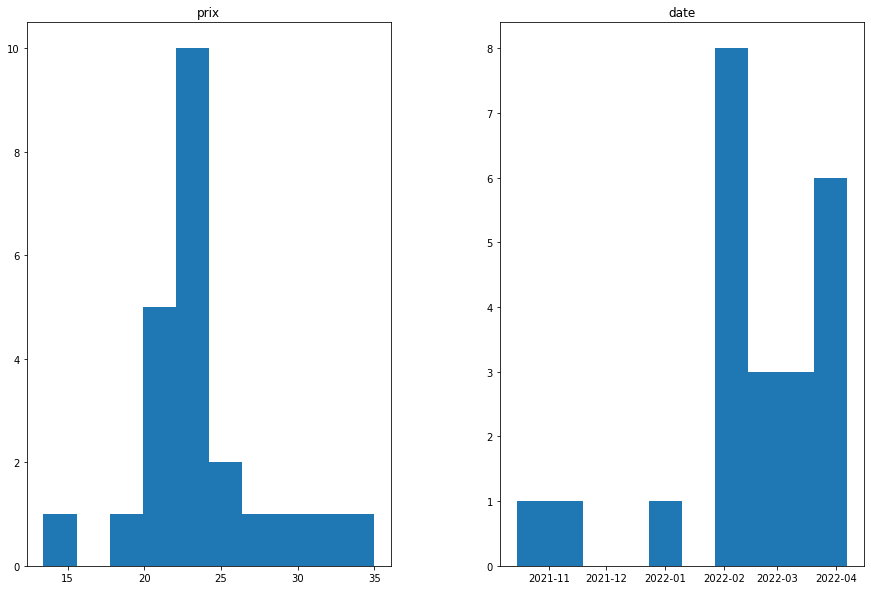

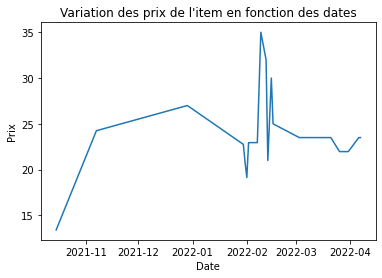

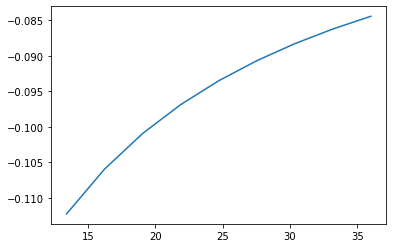

Comparaison des scores entre training, validation et test :  0.24083632340798078 -0.13039898670135597 -1.094863590668318
train error 13.297296237151837
test error 14.090541446969496
R^2 (best possible value is 1.0) : -1.094863590668318
The mean absolute error is: 3.58


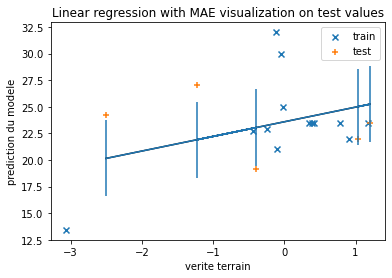

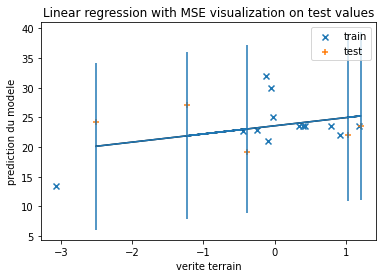

prices/specialist-gloves-crimson-kimono-field-tested_EU2.csv processing...
(50, 2)
prix           float64
date    datetime64[ns]
dtype: object
           prix
count    49.000
mean    906.429
std     102.422
min     700.000
25%     805.000
50%     916.540
75%     917.550
max    1182.800


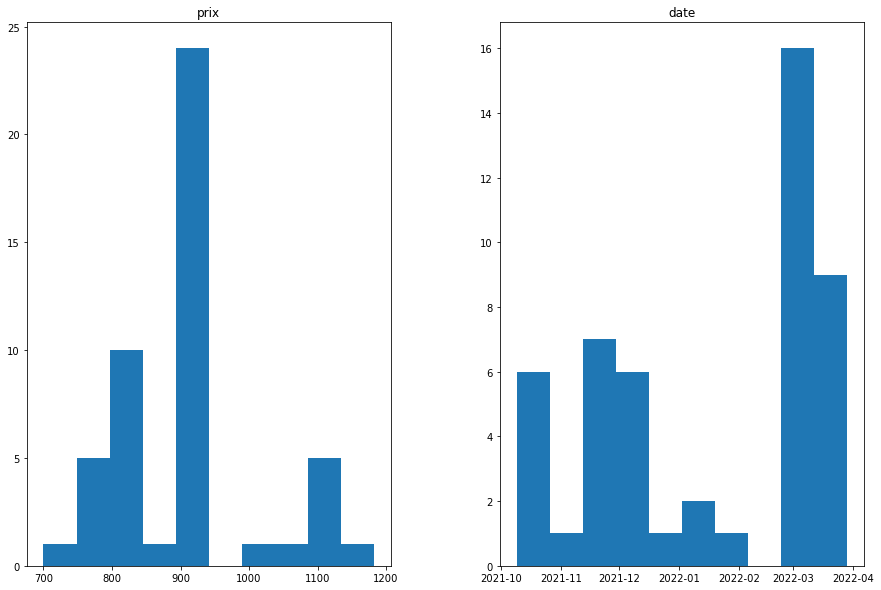

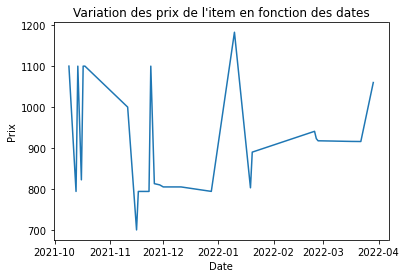

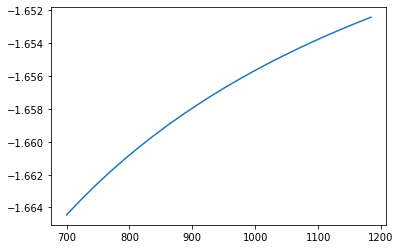

Comparaison des scores entre training, validation et test :  0.06084061484758274 -2.118087315732487 -3.573369989961752
train error 10087.863431708116
test error 15191.001182021797
R^2 (best possible value is 1.0) : -3.573369989961752
The mean absolute error is: 101.21


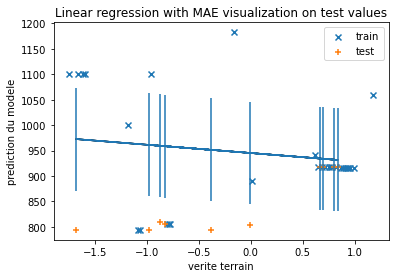

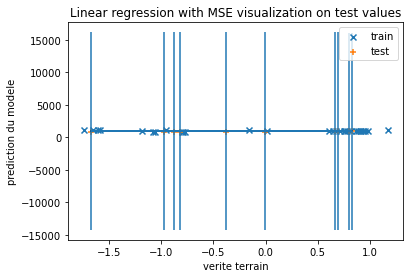

prices/awp-wildfire-field-tested_EU3.csv processing...
(169, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  169.000
mean    38.895
std      3.884
min     31.850
25%     34.930
50%     39.700
75%     41.890
max     46.130


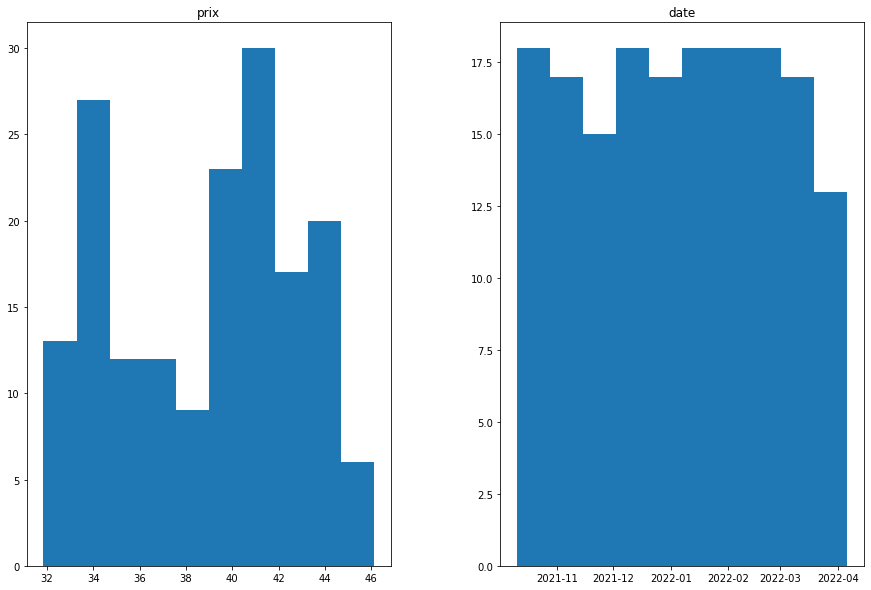

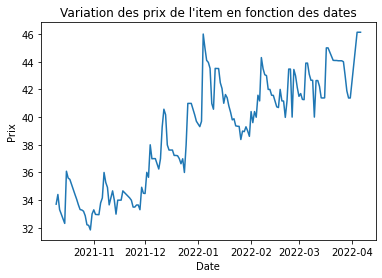

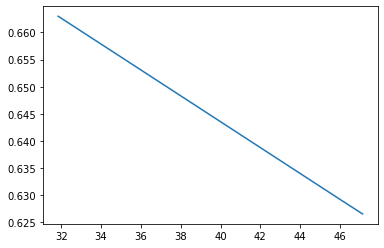

Comparaison des scores entre training, validation et test :  0.8091321405500483 0.7261704422342936 0.668100119640843
train error 2.977607979213746
test error 4.272291516564579
R^2 (best possible value is 1.0) : 0.668100119640843
The mean absolute error is: 1.57


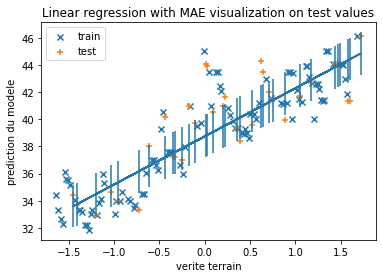

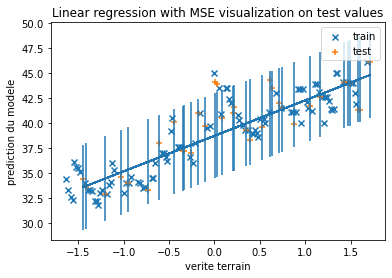

prices/huntsman-knife-rust-coat-battle-scarred_EU1.csv processing...
(44, 2)
prix           float64
date    datetime64[ns]
dtype: object
         prix
count  44.000
mean   71.841
std     5.246
min    66.000
25%    67.000
50%    72.445
75%    74.948
max    85.000


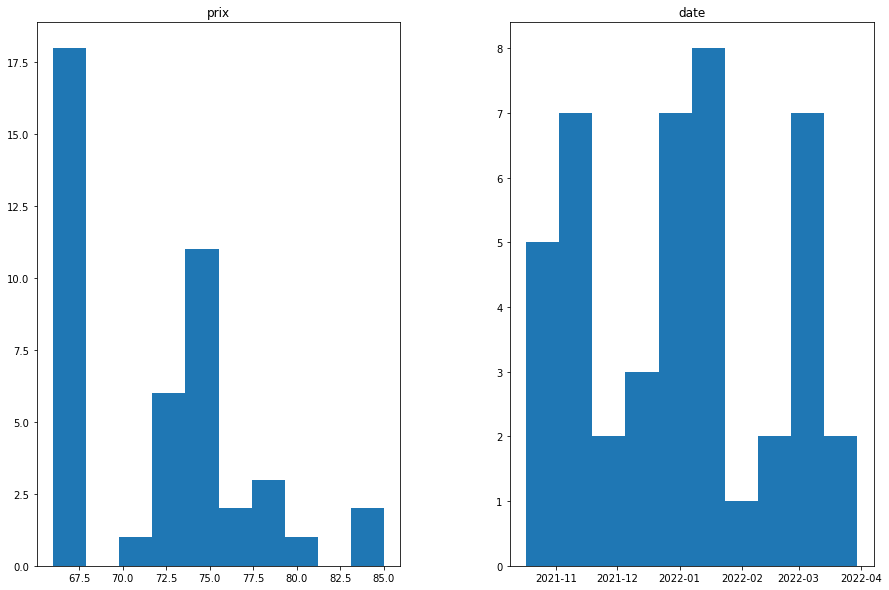

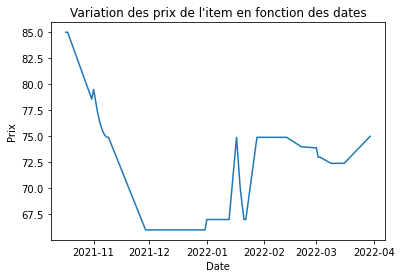

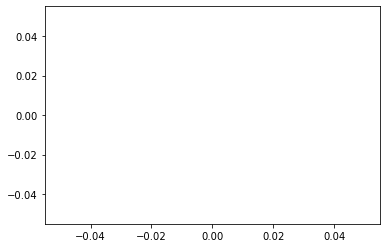

ValueError: attempt to get argmax of an empty sequence

In [17]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import *
import sklearn.linear_model
import sklearn.preprocessing
import os
import statistics
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

def remove_nonsense_data(array, dataset): # in our case, nonsense data means a too expensive skin/item, always alone in our datasets (happily !)
    maximum = np.max(array)
    i_max = np.where(array == maximum)
    second_max = 0
    for nb in array:
        if second_max < nb and nb!=maximum:
            second_max = nb
    
    percentage_diff = ((maximum-second_max)/maximum)*100
    if percentage_diff>20: # if difference between most and second expensive items is >2%
        dataset = dataset.drop(dataset[dataset.prix == maximum].index)
    
    return dataset

def apprendre_skin(filename):
    print(filename + " processing...")
    dataset = pd.read_csv(filename)

    dataset["prix"] = dataset["prix"].astype(float)
    dataset["date"] = pd.to_datetime(dataset["date"])

    # analyses sommaires
    print(dataset.shape)

    # on consulte les types des données:
    print(dataset.dtypes)
    
    # Removing non-sense data
    dataset = remove_nonsense_data(dataset['prix'].values, dataset)

    # aperçu des stats de chaque colonne
    pd.set_option('precision', 3)
    print(dataset.describe())
    
    # histograms
    dataset.hist(bins=10,figsize=(15,10),grid=False)
    plt.show()

    # Setting X and Y axis
    x = dataset['date'].values
    x = x.reshape(-1,1)
    y = dataset['prix'].values
    
    plt.title("Variation des prix de l'item en fonction des dates")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.plot(x,y)
    plt.show()
    
    # Train / Validation / Test split (60%/20%/20%)
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=7)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=8) # 0.25 * 0.8 = 0.2


    alpha_values = np.linspace(dataset['prix'].min(), dataset['prix'].max()+1, dataset['prix'].idxmax()) # tous les datasets font max 180 lignes donc on peut se permettre une telle simplification

    # input standardization
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    scores = []
    for alpha in alpha_values:
        # alpha est fixé (comme mu=mu0)
        monModele = sklearn.linear_model.Ridge(alpha=alpha)
    
        # je converge theta vers theta^*
        monModele.fit(X_train, Y_train)
    
        score = monModele.score(X_val, Y_val)
        scores.append(score)

    plt.plot(alpha_values, scores)
    plt.show()
    alpha_etoile = np.argmax(np.array(scores))

    # Fitting with fixed hyper-parameter
    monModele = sklearn.linear_model.Ridge(alpha=alpha_etoile)
    monModele.fit(X_train, Y_train)
    print("Comparaison des scores entre training, validation et test : ", monModele.score(X_train, Y_train), monModele.score(X_val, Y_val), monModele.score(X_test, Y_test))
    
    # Predictions
    Y_train_pred = monModele.predict(X_train)
    print("train error", sklearn.metrics.mean_squared_error(Y_train_pred, Y_train))

    Y_test_pred = monModele.predict(X_test)
    mse = sklearn.metrics.mean_squared_error(Y_test_pred, Y_test)
    print("test error", mse)
    
    # R^2 calculation
    print("R^2 (best possible value is 1.0) :", sklearn.metrics.r2_score(Y_test,Y_test_pred))
    
    # MAE calculation
    mae = sklearn.metrics.mean_absolute_error(Y_test,Y_test_pred)
    print("The mean absolute error is: {:.2f}".format(mae))
    
    # ----- Cross-validation -----
    # kfold_validation=KFold(5)

    # results=cross_val_score(monModele,x,y,cv=kfold_validation)
    # print(results)
    # print(np.mean(results))

    xmin= min(Y_train.min(), Y_train_pred.min() )-1
    xmax= max(Y_train.max(), Y_train_pred.max() )+1
    
    # Visualization with MAE on test values
    plt.scatter(X_train, Y_train, marker='x', label='train')
    plt.scatter(X_test , Y_test, marker='+', label='test')
    
    plt.legend()
    plt.title("Linear regression with MAE visualization on test values")
    plt.xlabel('verite terrain')
    plt.ylabel('prediction du modele')
    plt.errorbar(X_test,Y_test_pred,mae)
    # plt.xlim([xmin,xmax])
    # plt.ylim([xmin,xmax])
    plt.plot(X_test, Y_test_pred, color = "black")
    plt.show()

    
    # Visualization with MSE on test values
    plt.scatter(X_train, Y_train, marker='x', label='train')
    plt.scatter(X_test , Y_test, marker='+', label='test')
    
    plt.legend()
    plt.title("Linear regression with MSE visualization on test values")
    plt.xlabel('verite terrain')
    plt.ylabel('prediction du modele')
    plt.errorbar(X_test,Y_test_pred,mse)
    # plt.xlim([xmin,xmax])
    # plt.ylim([xmin,xmax])
    plt.plot(X_test, Y_test_pred, color = "black")
    plt.show()
    
for csv_file in os.listdir('prices'):
    if csv_file.endswith(".csv"):
        apprendre_skin("prices/"+csv_file)